<a href="https://colab.research.google.com/github/hnryjsph/Training-R-CNN-with-ResNet-50/blob/main/SSD_with_mobilenetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ Step 1: Install dependencies
!pip install roboflow
!pip install pycocotools
!pip install matplotlib scikit-learn




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [3]:
# ✅ Step 2: Download dataset from Roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="O466H8chxDAKF7O5Yuil")
project = rf.workspace("davidbottle-defect-inspection").project("bottle-fill-level-and-cap-detec")
version = project.version(9)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bottle-fill-level-and-cap-detec-9 in coco:: 100%|██████████| 816/816 [00:00<00:00, 2723.51it/s]


In [5]:
# ✅ Step 3: Prepare dataset
import os
import torch
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import torchvision
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
import torchvision.transforms.functional as F
from pycocotools.coco import COCO

#data_dir = os.path.join(dataset_path.location, "train")  # COCO format folders: 'train', 'valid'

# Custom transforms
class ComposeTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __call__(self, image, target):
        image = self.transform(image)
        return image, target

# Custom dataset class
class CocoDetectionTransform(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        target = {"boxes": [], "labels": []}
        ann_ids = self.ids[idx]
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=ann_ids))
        for ann in anns:
            bbox = ann['bbox']
            # convert to x1, y1, x2, y2
            bbox[2] += bbox[0]
            bbox[3] += bbox[1]
            target["boxes"].append(torch.tensor(bbox))
            target["labels"].append(torch.tensor(ann['category_id']))
        target["boxes"] = torch.stack(target["boxes"]).float()
        target["labels"] = torch.stack(target["labels"]).long()
        if self._transforms:
            img, target = self._transforms(img, target)
        return img, target

# Load COCO-formatted dataset
dataset = CocoDetectionTransform(
    img_folder= "/content/bottle-fill-level-and-cap-detec-9/train",
    ann_file="/content/bottle-fill-level-and-cap-detec-9/train/_annotations.coco.json",
    transforms=ComposeTransform()
)

# Split into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
# ✅ Step 4: Load SSD with MobileNet v3 Backbone
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ssdlite320_mobilenet_v3_large(pretrained=True)
num_classes = len(dataset.coco.getCatIds()) + 1  # +1 for background
model.head.classification_head.num_classes = num_classes
model.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 93.9MB/s]


SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [15]:
# ✅ Step 5: Training function
import torch.optim as optim
import time

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
    return epoch_loss / len(data_loader)

# Train for 2 epochs (you can increase)
for epoch in range(5):
    loss = train_one_epoch(model, optimizer, train_loader, device)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 1.9799
Epoch 2, Loss: 2.3707
Epoch 3, Loss: 2.5272
Epoch 4, Loss: 2.3994
Epoch 5, Loss: 2.1840


In [20]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

model.eval()
all_preds = []
all_labels = []

# Binarizer for multi-label output
mlb = MultiLabelBinarizer(classes=list(range(1, len(dataset.coco.cats)+1)))  # classes from COCO (start at 1)

with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i in range(len(images)):
            output = outputs[i]
            target = targets[i]

            # Ground truth labels
            gt_labels = target['labels'].cpu().numpy()
            all_labels.append(gt_labels)

            # Predicted labels (filter by score)
            pred_labels = output['labels'].cpu().numpy()
            pred_scores = output['scores'].cpu().numpy()
            pred_labels_filtered = pred_labels[pred_scores > 0.5]  # keep only confident predictions
            all_preds.append(pred_labels_filtered)

# Binarize y_true and y_pred
y_true = mlb.fit_transform(all_labels)
y_pred = mlb.transform(all_preds)


In [21]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


Precision: 0.4178
Recall:    0.1360
F1 Score:  0.1247
Accuracy:  0.0000


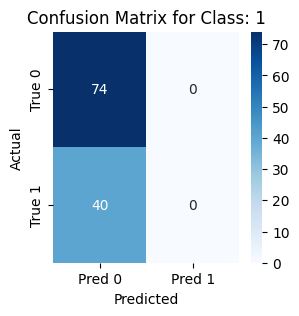

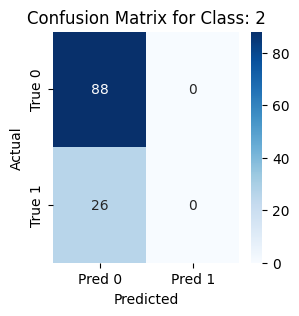

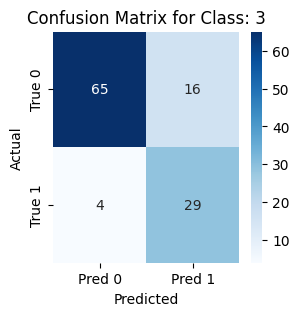

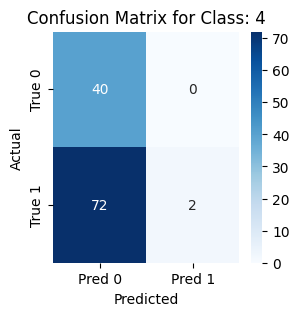

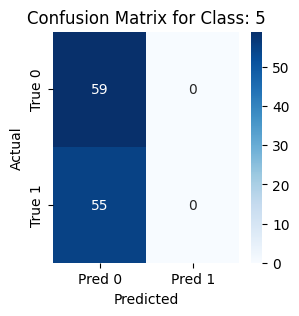

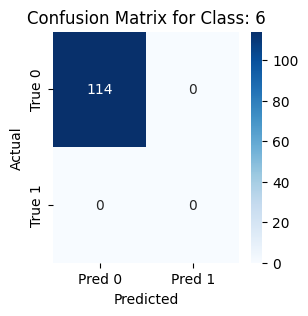

In [22]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get class labels
class_names = mlb.classes_

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Plot confusion matrix for each class
for i in range(len(class_names)):
    cm = mcm[i]
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix for Class: {class_names[i]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


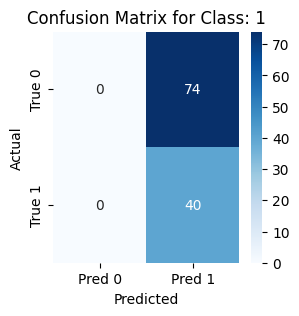

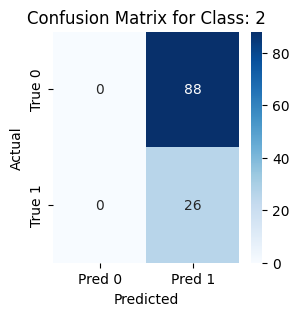

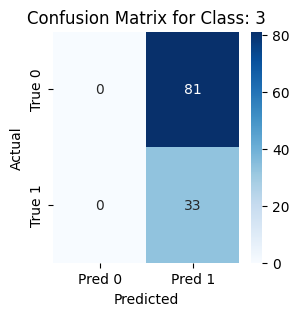

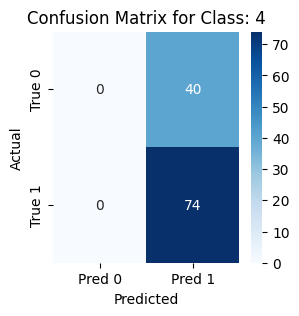

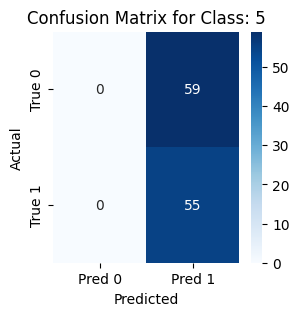

In [18]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get class labels
class_names = mlb.classes_

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Plot confusion matrix for each class
for i in range(len(class_names)):
    cm = mcm[i]
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix for Class: {class_names[i]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
